# Tree classifier

### Source

In [78]:
# -*- coding: utf-8 -*-
"""
@author: J. Salmon, A. Sabourin, A. Gramfort
"""

############################################################################
#                Import part
############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import fmod
import seaborn as sns

############################################################################
#                Data Generation
############################################################################


def rand_gauss(n=100, mu=[1, 1], sigma=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigma + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigma1=[0.1, 0.1],
                  sigma2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with std deviation sigma1, sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))]),
                     np.hstack([ex3, 3. * np.ones((n3, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1)
    x2 = np.vstack([sigma2 * np.random.randn(n2),
                    sigma2 * np.random.randn(n2) + 2.])
    res = np.hstack([np.vstack([[x0, x1], 1. * np.ones([1, n1])]),
                     np.vstack([x2, 2. * np.ones([1, n2])])]).T
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_checkers(n1=100, n2=100, n3=100, n4=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nb1 = n1 // 8
    nb2 = n2 // 8
    nb3 = n3 // 8
    nb4 = n4 // 8

    xapp = np.reshape(np.zeros((nb1 + nb2 + nb3 + nb4) * 16),
                      [(nb1 + nb2 + nb3 + nb4) * 8, 2])
    yapp = np.ones((nb1 + nb2 + nb3 + nb4) * 8)
    idx = 0
    nb = 2 * nb1
    for i in range(-2, 2):
        for j in range(-2, 2):
            yapp[idx:(idx + nb)] = [fmod(i - j + 100, 4)] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nb1 + nb2 + nb3 + nb4) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :])


############################################################################
#            Displaying labeled data
############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=color_blind_list[i], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


def plot_2d_simple(data, y=None):
    if y is None:
        plt.scatter(data[:, 0], data[:, 1], s=50)
    else:
        nY = len(y)
        y = y.astype(int)
        Ycol = [collist[y[i] - 1 % len(collist)] for i in range(nY)]
        plt.scatter(data[:, 0], data[:, 1], c=Ycol, s=40)

############################################################################
#            Displaying tools for the Frontiere
############################################################################


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

### Generate a dataset using source

In [92]:
n1 = 114
n2 = 114
n3 = 114
n4 = 114
sigma = 0.1
data = rand_checkers(n1, n2,n3,n4,sigma)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

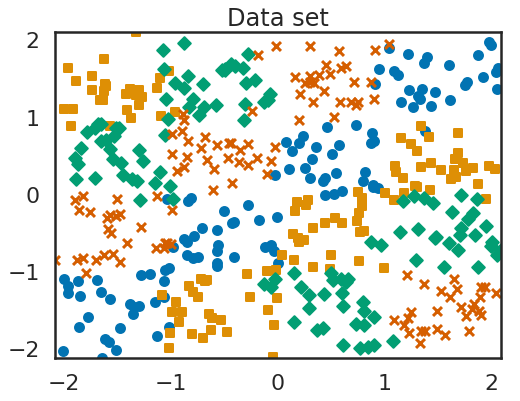

In [93]:
plt.title('Data set')
plot_2d(data[:, :2], data[:, 2], w=None)

### Fitting the dataset and evaluating 

In [94]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [95]:
X = data[:, :2]
y = data[:, 2].astype(int)

### Plot the boundary process

In [139]:
# Fitting the data with Gini criterion
dt_gini=DecisionTreeClassifier(criterion='gini')
dt_gini.fit(X,y)      

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [140]:
# Fitting the data with ENtropy criterion
dt_entropy=DecisionTreeClassifier(criterion='entropy')
dt_entropy.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [141]:
# Max depth and scores init
dmax = 15
scores_entropy = np.zeros(dmax)
scores_gini = np.zeros(dmax)

Separation rules using Gini index as impurity criterion:


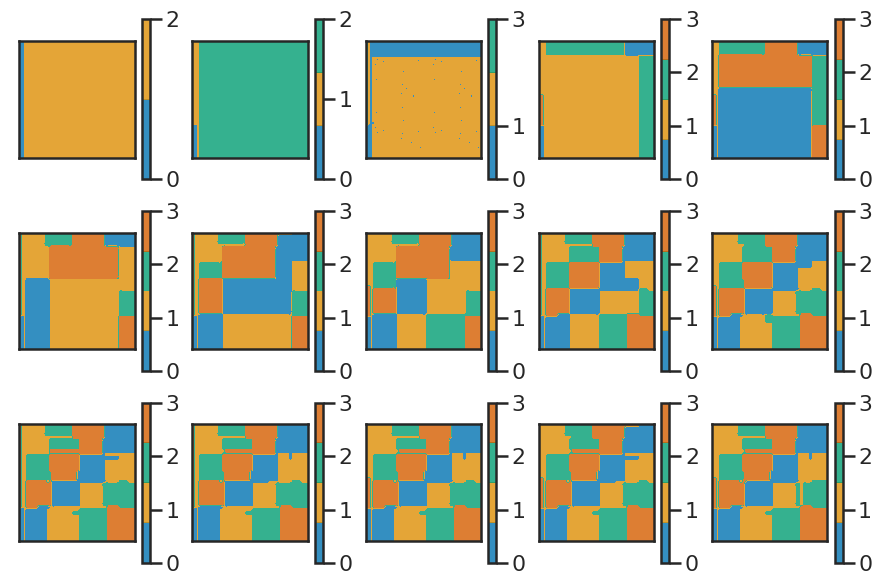

In [142]:
# Plot separation rules using Gini 
print("Separation rules using Gini index as impurity criterion:")
plt.figure(3, figsize=(15, 10))
for i in range(dmax):
    dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=i + 1)
    dt_gini.fit(X,y)
    scores_gini[i] = dt_gini.score(X,y)
    plt.subplot(3, 5, i + 1)
    # Set 'samples=True' to plot the data along with the frontier
    frontiere_new(lambda x: dt_gini.predict(x.reshape((1, -1))), X, y, step=50, samples=False)
plt.show()

Separation rules using entropy as impurity criterion:


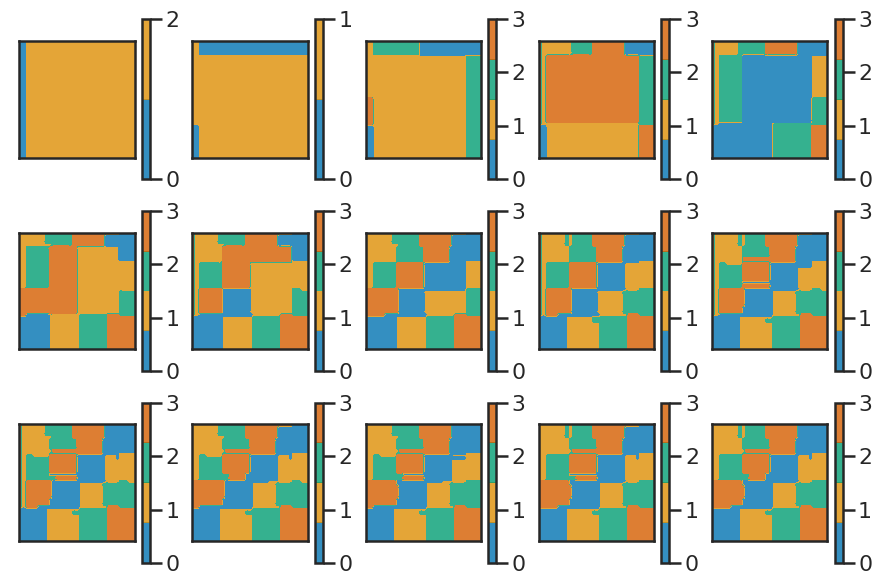

In [143]:
# Plot separation rules using entropy
print("Separation rules using entropy as impurity criterion:")
plt.close(2)
plt.figure(2, figsize=(15, 10))
for i in range(dmax):
    dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=i + 1)
    dt_entropy.fit(X, y)
    scores_entropy[i] = dt_entropy.score(X, y)
    plt.subplot(3, 5, i + 1)
    frontiere_new(lambda x: dt_entropy.predict(x.reshape((1, -1))), X, y, step=50, samples=False)
plt.show()

### Comparing scores

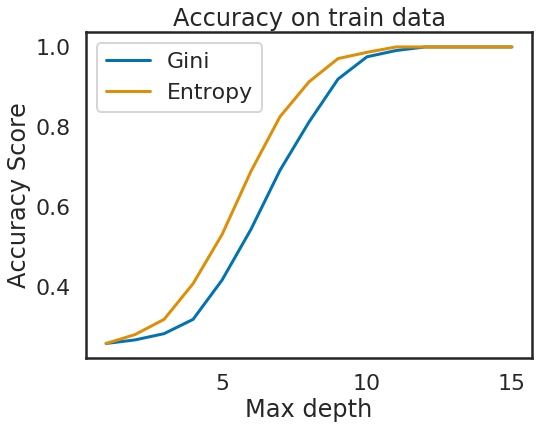

In [144]:
# Plot scores for Gini and Entropy

plt.plot(np.arange(1, dmax + 1), scores_gini, label='Gini')
plt.plot(np.arange(1, dmax + 1), scores_entropy, label='Entropy')
plt.title('Accuracy on train data')
plt.xlabel('Max depth')
plt.ylabel('Accuracy Score')
plt.legend()

### Let's observe the classifier result

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

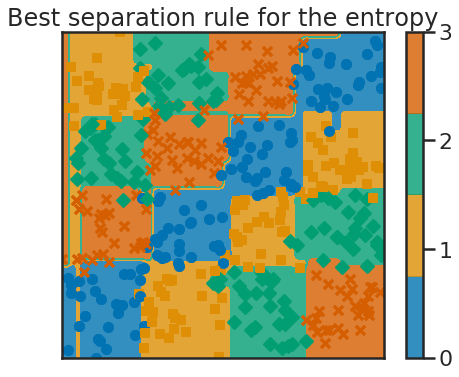

In [148]:
# For the entropy
dt_gini.max_depth = np.argmax(scores_gini) + 1
dt_gini.fit(X, y)
plot_2d(X, y)
plt.title("Best separation rule for the entropy")
frontiere_new(lambda x: dt_gini.predict(x.reshape((1, -1))), X, y, step=50)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

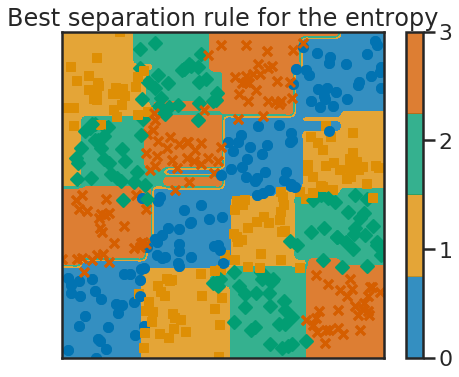

In [147]:
# For the entropy
dt_entropy.max_depth = np.argmax(scores_entropy) + 1
dt_entropy.fit(X, y)
plot_2d(X, y)
plt.title("Best separation rule for the entropy")
frontiere_new(lambda x: dt_entropy.predict(x.reshape((1, -1))), X, y, step=50)

### Test the decision tree on new datas

In [160]:
data_test = rand_checkers(40, 40, 40, 40, sigma)
X_test = data_test[:, :2]
y_test = data_test[:, 2].astype(int)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

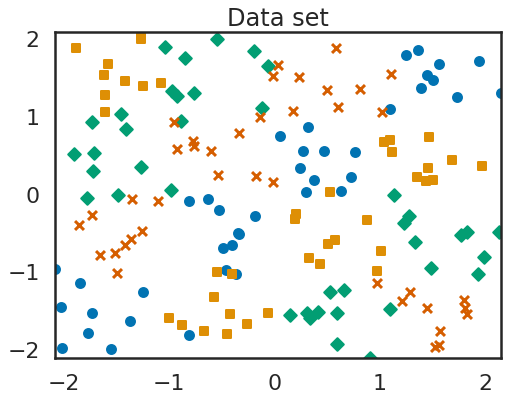

In [161]:
plt.title('Data set')
plot_2d(data_test[:, :2], data_test[:, 2], w=None)

In [162]:
# Max depth and score init
dmax = 15
scores_entropy = np.zeros(dmax)
scores_gini = np.zeros(dmax)

Separation rules using entropy as impurity criterion:


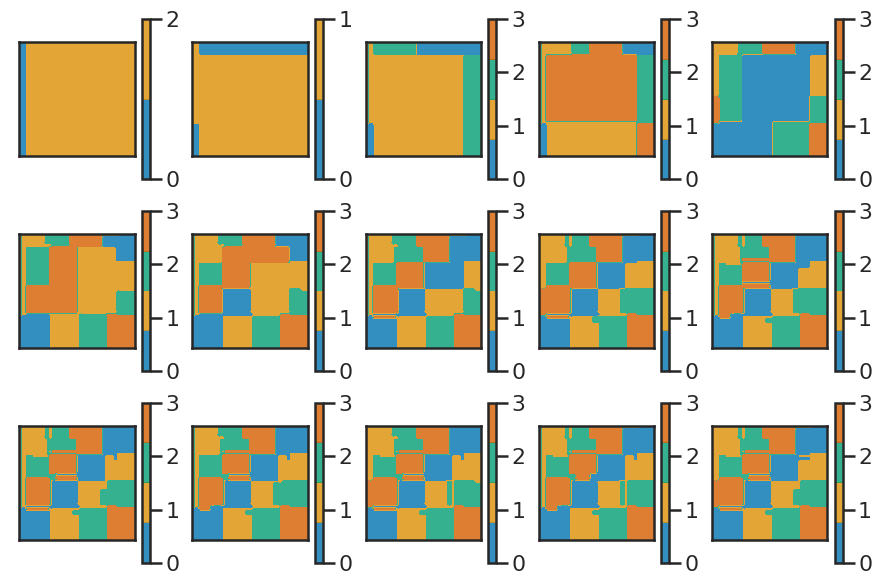

In [163]:
# Plot separation rules using entropy
print("Separation rules using entropy as impurity criterion:")
plt.figure(2, figsize=(15, 10))
for i in range(dmax):
    dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=i + 1)
    dt_entropy.fit(X, y)
    scores_entropy[i] = dt_entropy.score(X_test, y_test)
    plt.subplot(3, 5, i + 1)
    frontiere_new(lambda x: dt_entropy.predict(x.reshape((1, -1))), X_test, y_test, step=50, samples=False)
plt.show()

Separation rules using Gini index as impurity criterion:


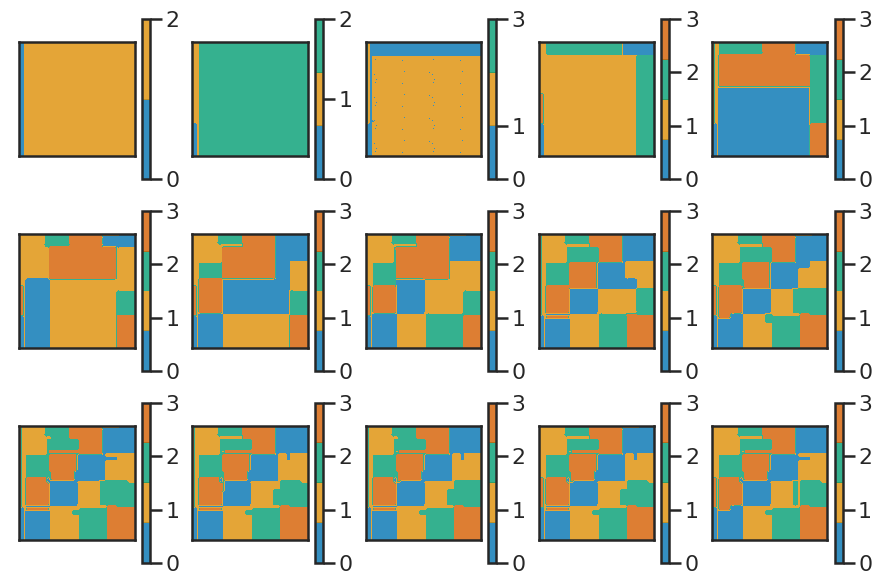

In [164]:
# Plot separation rules using Gini index
print("Separation rules using Gini index as impurity criterion:")
plt.figure(3, figsize=(15, 10))
for i in range(dmax):
    dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=i + 1)
    dt_gini.fit(X, y)
    scores_gini[i] = dt_gini.score(X_test, y_test)
    plt.subplot(3, 5, i + 1)
    # Set 'samples=True' to plot the data along with the frontier
    frontiere_new(lambda x: dt_gini.predict(x.reshape((1, -1))), X_test, y_test, step=50, samples=False)
plt.show()

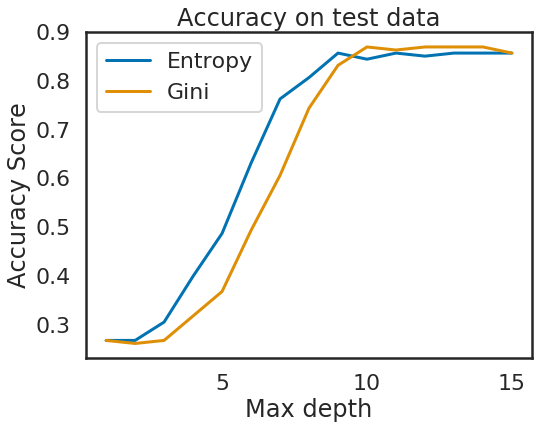

In [165]:
# Comparing scores

plt.plot(np.arange(1, dmax + 1), scores_entropy, label='Entropy')
plt.plot(np.arange(1, dmax + 1), scores_gini, label='Gini')
plt.title('Accuracy on test data')
plt.xlabel('Max depth')
plt.ylabel('Accuracy Score')
plt.legend()

## Classify digits dataset using decision trees

In [53]:
from sklearn import datasets,metrics

In [54]:
digits = datasets.load_digits()

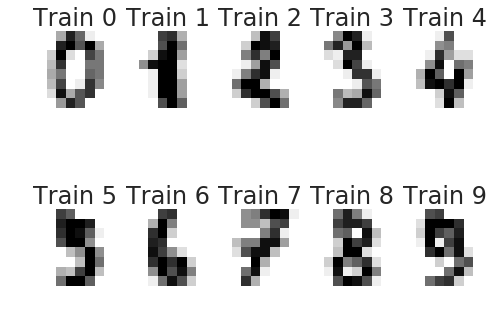

In [55]:
# Take a look at the data
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Train %i'  % label)

In [170]:
# Fitting on the data
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
clf=DecisionTreeClassifier(criterion='gini')
clf.fit(data[:int(n_samples * 0.8) ], digits.target[:int(n_samples * 0.8 )])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [171]:
# Separate expected and predictef values in order to have different metrics
expected = digits.target[int(n_samples*0.2):]
predicted = clf.predict(data[int(n_samples*0.2):])

Classification report for classifier DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       140
           1       0.95      0.90      0.93       144
           2       0.99      0.95      0.97       141
           3       0.93      0.92      0.92       145
           4       0.96      0.95      0.96       147
           5       0.96      0.95      0.95       146
           6       0.96      0.99      0.98       145
           7       0.93      0.97      0.95       144
           8       0.92      0.94      0.93       140
           9       0.92      0.93      0.93       146

   micro avg    

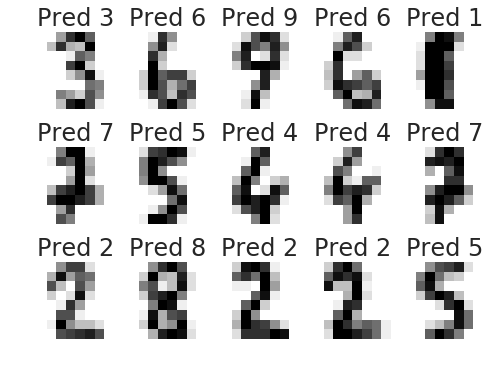

In [172]:
# Summary of the performances using different metrics 
# and some predicted labels for some images

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

images_and_predictions = list(zip(digits.images[int(n_samples*0.2):], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:15]):
    plt.subplot(3, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Pred %i' % prediction)

plt.show()

In [179]:
# We will use cross validation to comapre the results with various splits
X = digits.data
y = digits.target
clf_entropy=DecisionTreeClassifier(criterion='entropy')

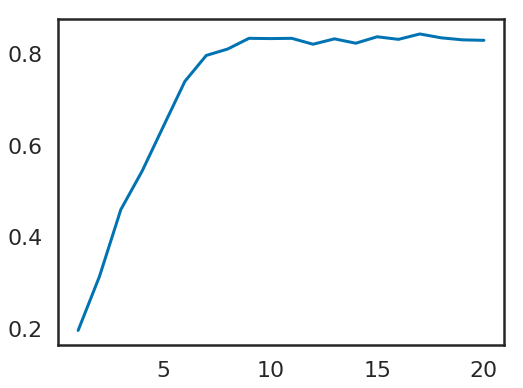

In [180]:
# Get the score evolution with the depth on different split
depth_basis=np.linspace(1,20,20)
scores_ent=[]
for depth in depth_basis:
    clf_entropy=DecisionTreeClassifier(criterion='entropy',max_depth=depth)
    cv = cross_val_score(clf_entropy, X, y, cv=10)
    scores_ent.append(np.mean(cv))
    
plt.plot(depth_basis,scores)

### Learning curve

In [183]:
# Using a pre-written script

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [188]:
from sklearn.model_selection import ShuffleSplit,learning_curve

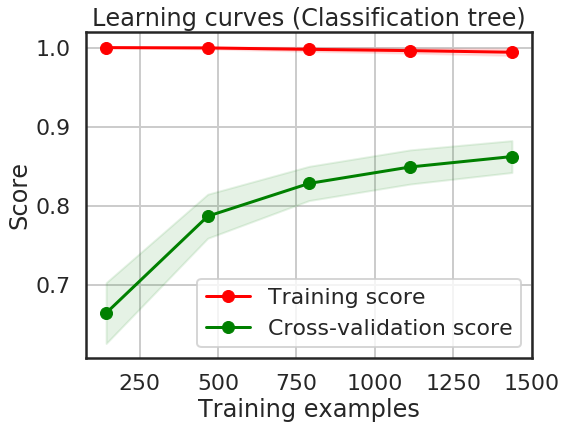

In [189]:
# Plotting the curve for our classifier

digits = datasets.load_digits()
X, y = digits.data, digits.target
title = "Learning curves (Classification tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=500, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=9)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)
plt.show()